# Forecasting Temperature
In this notebook, temperature forecasting is used so that predictions can be used as independent variable in load forecasting.

## Reading Temperature
Weighted Temperature dataframe was already prepared for use.

In [1]:
# Reading data
import pandas as pd
temp = pd.read_csv(r"C:\Users\singh\Desktop\TUD (All Semesters)\Courses - Semester 6 (TU Dresden)\Thesis Work\Exploratory Code\weighted_temperature.csv")
temp = temp[["timestamp", "temp_weighted"]]
temp[:2]

,timestamp,temp_weighted
0,2004-01-01 00:30:00,42.338937
1,2004-01-01 01:30:00,41.239284


In [2]:
# Latest temperature reading available
import numpy as np
np.max(temp.timestamp)

'2008-06-30 05:30:00'

The forecasting horizon is 1st week of Jul'08:
> from 1 July 2008 (00:30:00) to 7 July 2008 (23:30:00) 

For the previous 4 years, 1st week of july can be used as a test set.

### Visual Analysis
1st week of July for 4 years previous to 2008 are studied here. These periods can be used as test sets to evaluate prediction performance using various forecasting methods.

#### Lineplots

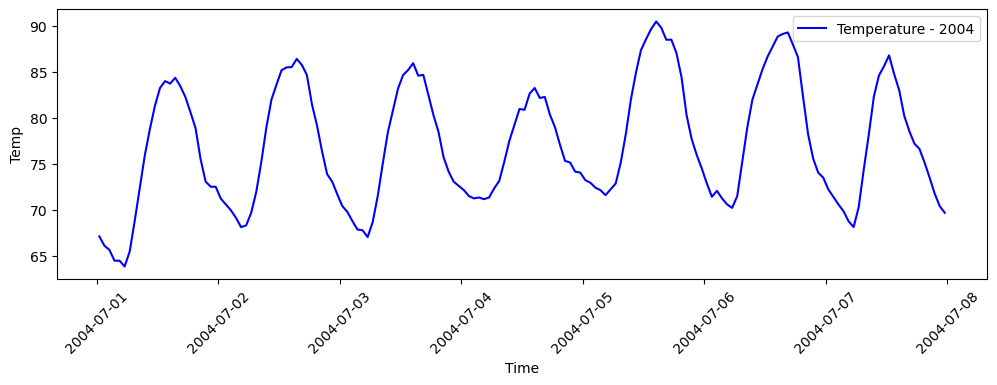

In [3]:
# Plotting temperature - 1st week of July 2004
import matplotlib.pyplot as plt

temp_jul04_week1 = temp.loc[(temp.timestamp >= "2004-07-01 00:30:00") & (temp.timestamp <= "2004-07-07 23:30:00"),:]

fig, ax = plt.subplots(figsize=(12,3.5))
ax.plot(pd.to_datetime(temp_jul04_week1.timestamp), np.array(temp_jul04_week1.temp_weighted).reshape(-1, 1), label="Temperature - 2004", color = "blue")
ax.set_xlabel("Time")
ax.set_ylabel("Temp")
ax.legend()
plt.xticks(rotation=45)
plt.show()

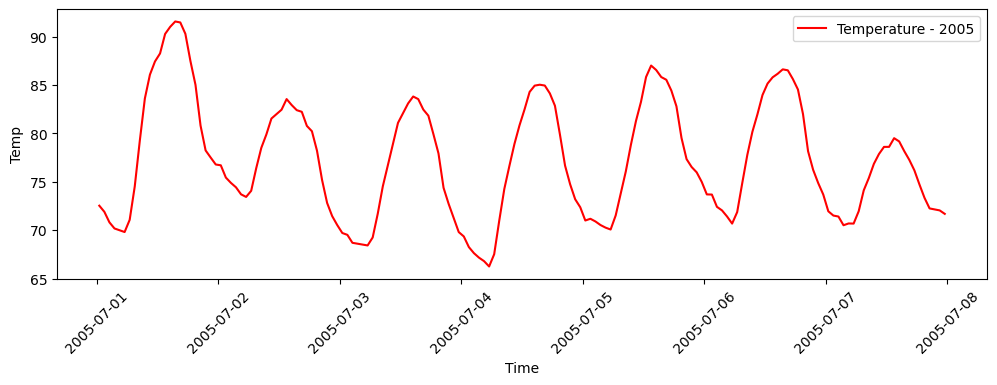

In [4]:
# Plotting temperature - 1st week of July 2005
import matplotlib.pyplot as plt

temp_jul05_week1 = temp.loc[(temp.timestamp >= "2005-07-01 00:30:00") & (temp.timestamp <= "2005-07-07 23:30:00"),:]

fig, ax = plt.subplots(figsize=(12,3.5))
ax.plot(pd.to_datetime(temp_jul05_week1.timestamp), np.array(temp_jul05_week1.temp_weighted).reshape(-1, 1), label="Temperature - 2005", color = "red")
ax.set_xlabel("Time")
ax.set_ylabel("Temp")
ax.legend()
plt.xticks(rotation=45)
plt.show()

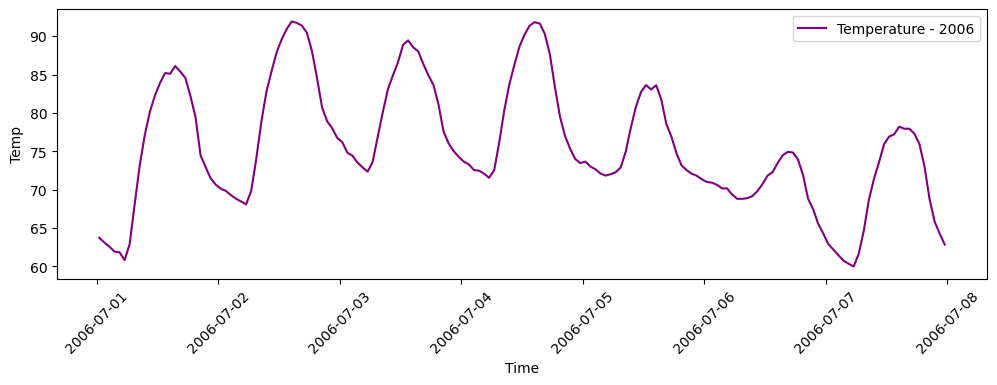

In [5]:
# Plotting temperature - 1st week of July 2006
import matplotlib.pyplot as plt

temp_jul06_week1 = temp.loc[(temp.timestamp >= "2006-07-01 00:30:00") & (temp.timestamp <= "2006-07-07 23:30:00"),:]

fig, ax = plt.subplots(figsize=(12,3.5))
ax.plot(pd.to_datetime(temp_jul06_week1.timestamp), np.array(temp_jul06_week1.temp_weighted).reshape(-1, 1), label="Temperature - 2006", color = "purple")
ax.set_xlabel("Time")
ax.set_ylabel("Temp")
ax.legend()
plt.xticks(rotation=45)
plt.show()

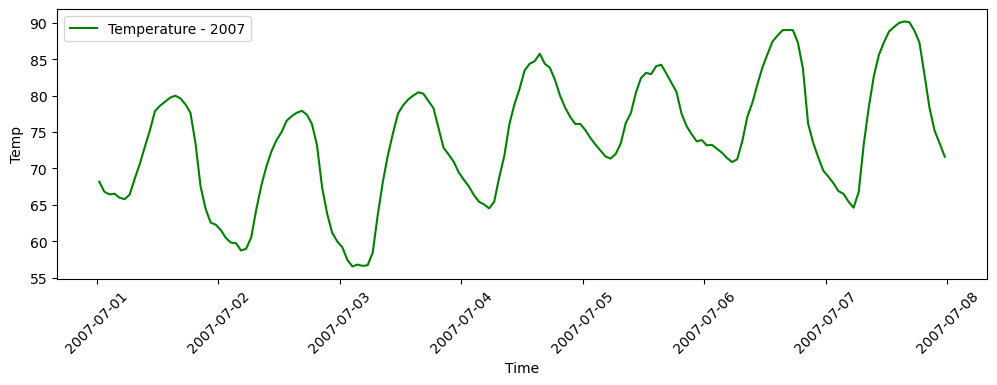

In [6]:
# Plotting temperature - 1st week of July 2007
import matplotlib.pyplot as plt

temp_jul07_week1 = temp.loc[(temp.timestamp >= "2007-07-01 00:30:00") & (temp.timestamp <= "2007-07-07 23:30:00"),:]

fig, ax = plt.subplots(figsize=(12,3.5))
ax.plot(pd.to_datetime(temp_jul07_week1.timestamp), np.array(temp_jul07_week1.temp_weighted).reshape(-1, 1), label="Temperature - 2007", color = "green")
ax.set_xlabel("Time")
ax.set_ylabel("Temp")
ax.legend()
plt.xticks(rotation=45)
plt.show()

There appears to be considerable periodic pattern and daily seasonality in temperature readings. However, the average level of the series appears to not be stable.

#### Checking Stationarity

In [7]:
# Defining a function to check if temperature is stationary
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')

In [8]:
# Checking stationarity for Week 1, Jul'04
check_stationarity(temp_jul04_week1.temp_weighted)

ADF Statistic: -2.926880214906054
p-value: 0.04231029875435811
Stationary


In [9]:
# Checking stationarity for Week 1, Jul'05
check_stationarity(temp_jul05_week1.temp_weighted)

ADF Statistic: -1.8834994767087743
p-value: 0.33986284510696424
Non-Stationary


In [10]:
# Checking stationarity for Week 1, Jul'06
check_stationarity(temp_jul06_week1.temp_weighted)

ADF Statistic: -1.2157678735009845
p-value: 0.6667762581799047
Non-Stationary


In [11]:
# Checking stationarity for Week 1, Jul'07
check_stationarity(temp_jul07_week1.temp_weighted)

ADF Statistic: -0.9196658907521962
p-value: 0.7814271925478806
Non-Stationary


#### ACFs and PACFs

Text(0, 0.5, 'ACF')

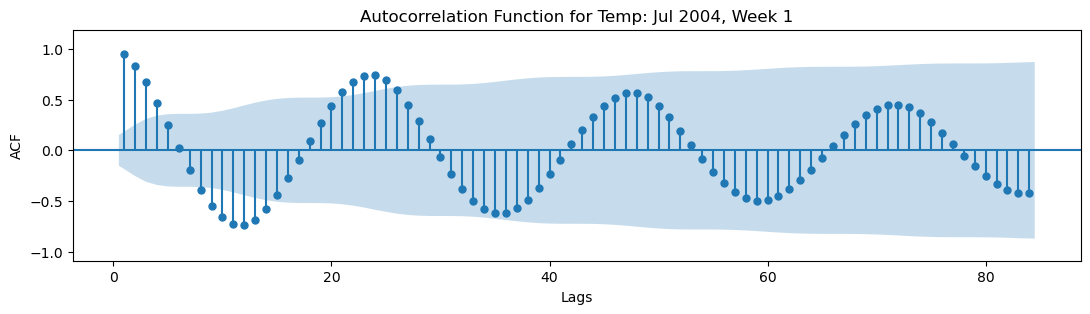

In [12]:
# Observing the ACF plot - Week 1 Jul 2004 
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(13,3))
plot_acf(temp_jul04_week1.temp_weighted, 
         lags = 84,
         ax=ax,
         zero=False, 
         bartlett_confint=True, 
         auto_ylims=True)

ax.set_title("Autocorrelation Function for Temp: Jul 2004, Week 1")
ax.set_xlabel("Lags")
ax.set_ylabel("ACF")

Text(0, 0.5, 'PACF')

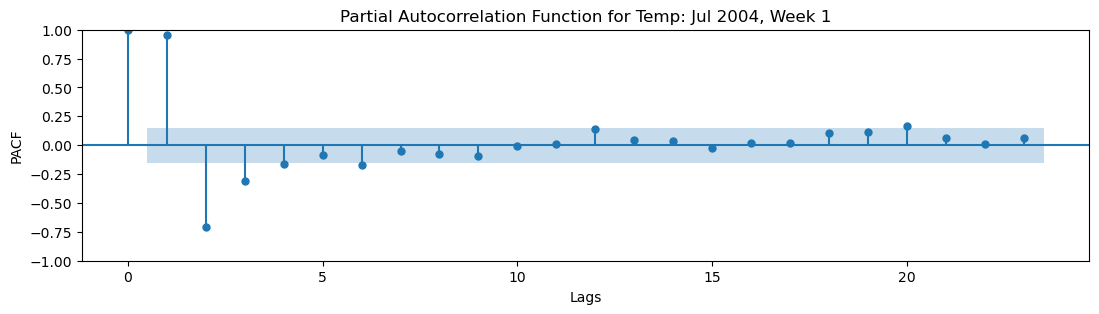

In [13]:
# Observing the ACF plot - Week 1 Jul 2004 
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(13,3))
plot_pacf(temp_jul04_week1.temp_weighted,
         ax=ax)

ax.set_title("Partial Autocorrelation Function for Temp: Jul 2004, Week 1")
ax.set_xlabel("Lags")
ax.set_ylabel("PACF")

- Considerable Autocorrelation, with good daily (24 hour) seasonality.
- Sinusoidal pattern in ACF suggests AR process.
- AR order likely <= 3, accroding to PACF although MA component might be present.

Text(0, 0.5, 'ACF')

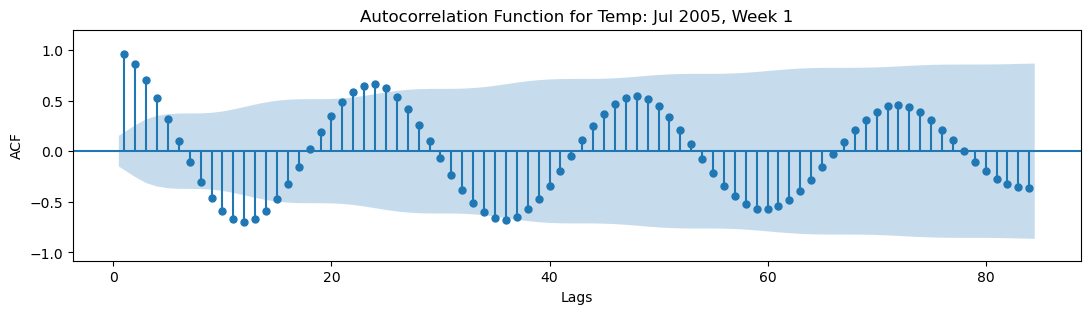

In [14]:
# Observing the ACF plot - Week 1 Jul 2005
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(13,3))
plot_acf(temp_jul05_week1.temp_weighted, 
         lags = 84,
         ax=ax,
         zero=False, 
         bartlett_confint=True, 
         auto_ylims=True)

ax.set_title("Autocorrelation Function for Temp: Jul 2005, Week 1")
ax.set_xlabel("Lags")
ax.set_ylabel("ACF")

Text(0, 0.5, 'PACF')

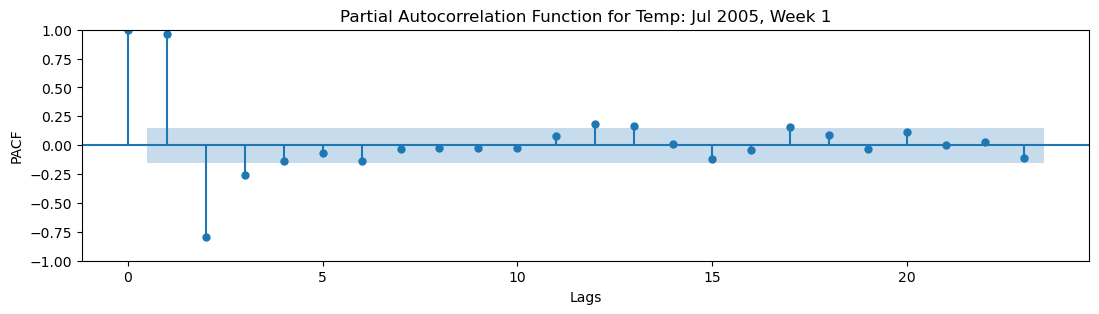

In [15]:
# Observing the ACF plot - Week 1 Jul 2005
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(13,3))
plot_pacf(temp_jul05_week1.temp_weighted,
         ax=ax)

ax.set_title("Partial Autocorrelation Function for Temp: Jul 2005, Week 1")
ax.set_xlabel("Lags")
ax.set_ylabel("PACF")

- Considerable Autocorrelation, with good daily (24 hour) seasonality.
- Sinusoidal pattern in ACF suggests AR process.
- AR order likely <= 3, accroding to PACF although MA component might be present.

Text(0, 0.5, 'ACF')

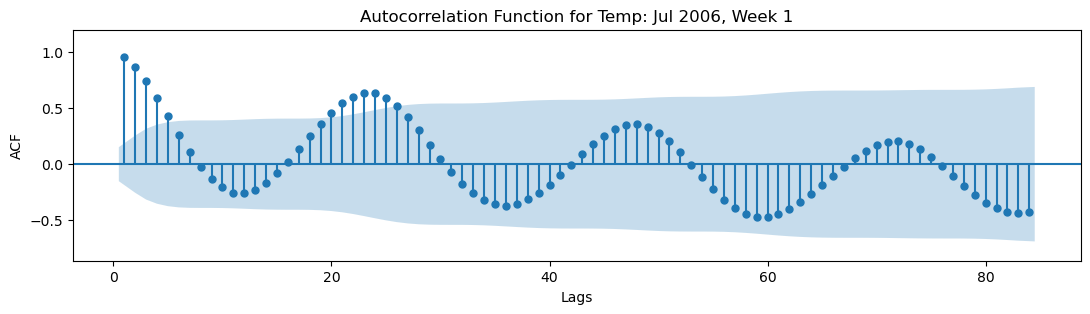

In [16]:
# Observing the ACF plot - Week 1 Jul 2006
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(13,3))
plot_acf(temp_jul06_week1.temp_weighted, 
         lags = 84,
         ax=ax,
         zero=False, 
         bartlett_confint=True, 
         auto_ylims=True)

ax.set_title("Autocorrelation Function for Temp: Jul 2006, Week 1")
ax.set_xlabel("Lags")
ax.set_ylabel("ACF")

Text(0, 0.5, 'PACF')

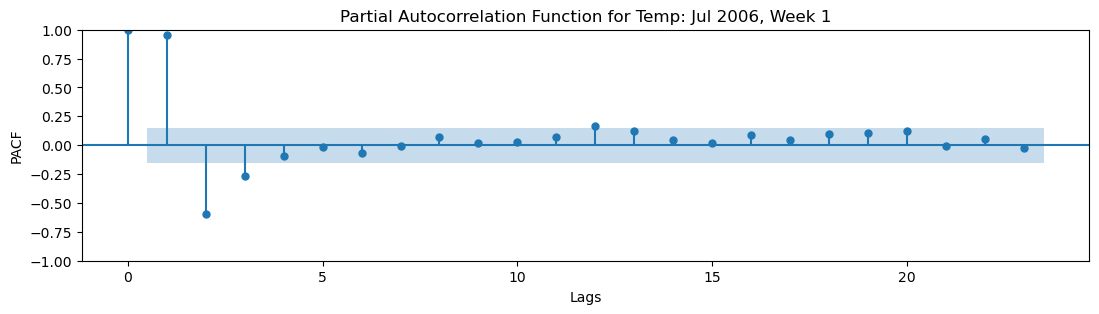

In [17]:
# Observing the ACF plot - Week 1 Jul 2006
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(13,3))
plot_pacf(temp_jul06_week1.temp_weighted,
         ax=ax)

ax.set_title("Partial Autocorrelation Function for Temp: Jul 2006, Week 1")
ax.set_xlabel("Lags")
ax.set_ylabel("PACF")

- Considerable Autocorrelation, with good daily (24 hour) seasonality.
- Sinusoidal pattern in ACF suggests AR process.
- AR order likely <= 3, accroding to PACF although MA component might be present.

Text(0, 0.5, 'ACF')

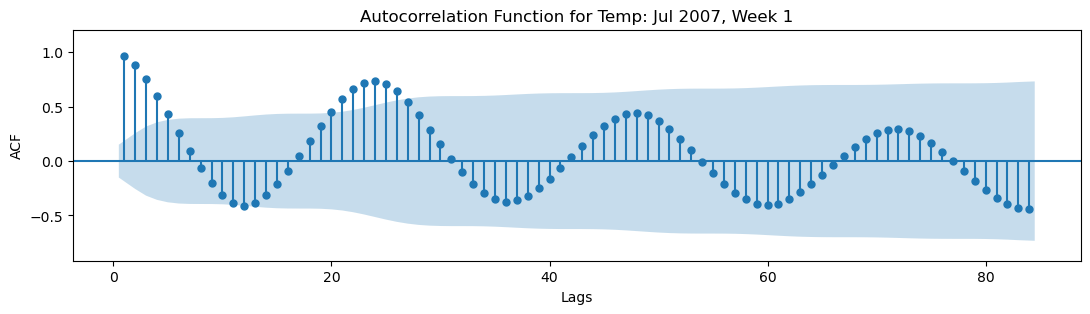

In [18]:
# Observing the ACF plot - Week 1 Jul 2007
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(13,3))
plot_acf(temp_jul07_week1.temp_weighted, 
         lags = 84,
         ax=ax,
         zero=False, 
         bartlett_confint=True, 
         auto_ylims=True)

ax.set_title("Autocorrelation Function for Temp: Jul 2007, Week 1")
ax.set_xlabel("Lags")
ax.set_ylabel("ACF")

Text(0, 0.5, 'PACF')

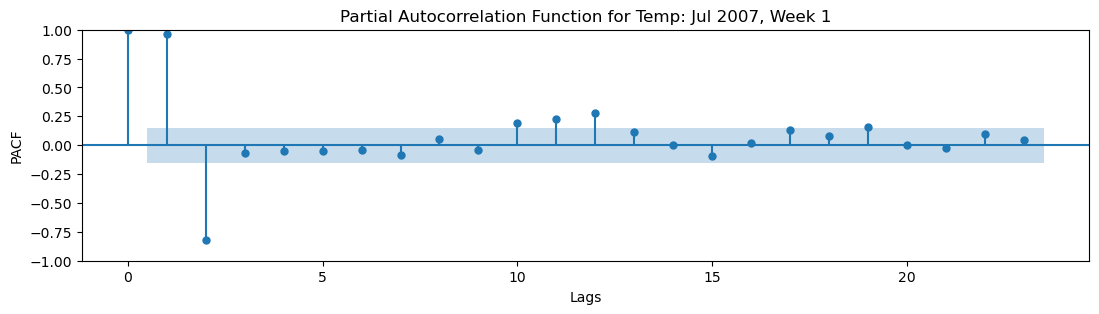

In [19]:
# Observing the ACF plot - Week 1 Jul 2007
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(13,3))
plot_pacf(temp_jul07_week1.temp_weighted,
         ax=ax)

ax.set_title("Partial Autocorrelation Function for Temp: Jul 2007, Week 1")
ax.set_xlabel("Lags")
ax.set_ylabel("PACF")

- Considerable Autocorrelation, with good daily (24 hour) seasonality.
- Sinusoidal pattern in ACF suggests AR process.
- AR order likely <= 2, accroding to PACF although MA component might be present.

### Testing Performance
As performance metrics, MAPE and R2 scores are averaged over the 4 periods in 2004, 2005, 2006 and 2007.

#### Naive: Repeating Last Cycle

In [20]:
from sklearn.metrics import mean_squared_error

# Generating Naive signals
last_cycle_temp_jul04_week1 = temp.loc[(temp.timestamp >= "2004-06-24 00:30:00") & (temp.timestamp <= "2004-06-30 23:30:00"),:]
last_cycle_temp_jul05_week1 = temp.loc[(temp.timestamp >= "2005-06-24 00:30:00") & (temp.timestamp <= "2005-06-30 23:30:00"),:]
last_cycle_temp_jul06_week1 = temp.loc[(temp.timestamp >= "2006-06-24 00:30:00") & (temp.timestamp <= "2006-06-30 23:30:00"),:]
last_cycle_temp_jul07_week1 = temp.loc[(temp.timestamp >= "2007-06-24 00:30:00") & (temp.timestamp <= "2007-06-30 23:30:00"),:]

# Initiating empty lists
r2_scores_naive=[]
rmse_scores_naive=[]

# Calculating r2 scores over four periods
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import numpy as np
r2_scores_naive.append(r2_score(np.array(temp_jul04_week1.temp_weighted), np.array(last_cycle_temp_jul04_week1.temp_weighted)))
r2_scores_naive.append(r2_score(np.array(temp_jul05_week1.temp_weighted), np.array(last_cycle_temp_jul05_week1.temp_weighted)))
r2_scores_naive.append(r2_score(np.array(temp_jul06_week1.temp_weighted), np.array(last_cycle_temp_jul06_week1.temp_weighted)))
r2_scores_naive.append(r2_score(np.array(temp_jul07_week1.temp_weighted), np.array(last_cycle_temp_jul07_week1.temp_weighted)))

# Calculating rmse scores over four periods
rmse_scores_naive.append(np.sqrt(mean_squared_error(np.array(temp_jul04_week1.temp_weighted), np.array(last_cycle_temp_jul04_week1.temp_weighted))))
rmse_scores_naive.append(np.sqrt(mean_squared_error(np.array(temp_jul05_week1.temp_weighted), np.array(last_cycle_temp_jul05_week1.temp_weighted))))
rmse_scores_naive.append(np.sqrt(mean_squared_error(np.array(temp_jul06_week1.temp_weighted), np.array(last_cycle_temp_jul06_week1.temp_weighted))))
rmse_scores_naive.append(np.sqrt(mean_squared_error(np.array(temp_jul07_week1.temp_weighted), np.array(last_cycle_temp_jul07_week1.temp_weighted))))

# Averaging over 4 period
print(f"Avg r2 score from naive approach: {np.mean(r2_scores_naive)}")
print(f"Avg RMSE score from naive approach: {np.mean(rmse_scores_naive)}")

Avg r2 score from naive approach: 0.2720306921098904
Avg RMSE score from naive approach: 6.132220036518656


#### Exponential Smoothing: Holt Winter's Additive Method

In [21]:
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Generating ES Models
es_temp_jul04_week1 = ExponentialSmoothing(
    temp.loc[(temp.timestamp >= "2004-06-17 00:30:00") & (temp.timestamp <= "2004-06-30 23:30:00"),"temp_weighted"].reset_index(drop=True),
    seasonal="add",         # additive seasonality
    seasonal_periods=24     # 24th hour i.e. daily seasonality
).fit()

es_temp_jul05_week1 = ExponentialSmoothing(
    temp.loc[(temp.timestamp >= "2005-06-17 00:30:00") & (temp.timestamp <= "2005-06-30 23:30:00"),"temp_weighted"].reset_index(drop=True),
    seasonal="add",         # additive seasonality
    seasonal_periods=24     # 24th hour i.e. daily seasonality
).fit()

es_temp_jul06_week1 = ExponentialSmoothing(
    temp.loc[(temp.timestamp >= "2006-06-17 00:30:00") & (temp.timestamp <= "2006-06-30 23:30:00"),"temp_weighted"].reset_index(drop=True),
    seasonal="add",         # additive seasonality
    seasonal_periods=24     # 24th hour i.e. daily seasonality
).fit()

es_temp_jul07_week1 = ExponentialSmoothing(
    temp.loc[(temp.timestamp >= "2007-06-17 00:30:00") & (temp.timestamp <= "2007-06-30 23:30:00"),"temp_weighted"].reset_index(drop=True),
    seasonal="add",         # additive seasonality
    seasonal_periods=24     # 24th hour i.e. daily seasonality
).fit()

# Next Week Forecasts
forecast_es_temp_jul04_week1 = es_temp_jul04_week1.forecast(len(temp_jul04_week1))
fitted_es_temp_jul04_week1 = es_temp_jul04_week1.fittedvalues

forecast_es_temp_jul05_week1 = es_temp_jul05_week1.forecast(len(temp_jul05_week1))
fitted_es_temp_jul05_week1 = es_temp_jul05_week1.fittedvalues

forecast_es_temp_jul06_week1 = es_temp_jul06_week1.forecast(len(temp_jul06_week1))
fitted_es_temp_jul06_week1 = es_temp_jul06_week1.fittedvalues

forecast_es_temp_jul07_week1 = es_temp_jul07_week1.forecast(len(temp_jul07_week1))
fitted_es_temp_jul07_week1 = es_temp_jul07_week1.fittedvalues

In [22]:
# Calculating error scores on test
from sklearn.metrics import mean_squared_error

# Initiating empty lists
r2_scores_es=[]
rmse_scores_es=[]

# Calculating r2 scores over four periods
r2_scores_es.append(r2_score(np.array(temp_jul04_week1.temp_weighted), np.array(forecast_es_temp_jul04_week1)))
r2_scores_es.append(r2_score(np.array(temp_jul05_week1.temp_weighted), np.array(forecast_es_temp_jul05_week1)))
r2_scores_es.append(r2_score(np.array(temp_jul06_week1.temp_weighted), np.array(forecast_es_temp_jul06_week1)))
r2_scores_es.append(r2_score(np.array(temp_jul07_week1.temp_weighted), np.array(forecast_es_temp_jul07_week1)))

# Calculating rmse scores over four periods
rmse_scores_es.append(np.sqrt(mean_squared_error(np.array(temp_jul04_week1.temp_weighted), np.array(forecast_es_temp_jul04_week1))))
rmse_scores_es.append(np.sqrt(mean_squared_error(np.array(temp_jul05_week1.temp_weighted), np.array(forecast_es_temp_jul05_week1))))
rmse_scores_es.append(np.sqrt(mean_squared_error(np.array(temp_jul06_week1.temp_weighted), np.array(forecast_es_temp_jul06_week1))))
rmse_scores_es.append(np.sqrt(mean_squared_error(np.array(temp_jul07_week1.temp_weighted), np.array(forecast_es_temp_jul07_week1))))

# Averaging over 4 period
print(f"Avg r2 score from naive approach: {np.mean(r2_scores_es)}")
print(f"Avg RMSE score from naive approach: {np.mean(rmse_scores_es)}")

Avg r2 score from naive approach: 0.46942162575070623
Avg RMSE score from naive approach: 5.205092326365845


Compared to naive method, ES improves test performance.

#### Simple SARIMA
Note: most temperature periods were found to be non-stationary

##### Does Seasonal Differencing Work?

In [23]:
# Calculating seasonally differenced temperature
temp["temp_s_diff"] = temp["temp_weighted"].diff(24)
temp[0:2]

,timestamp,temp_weighted,temp_s_diff
0,2004-01-01 00:30:00,42.338937,NaN
1,2004-01-01 01:30:00,41.239284,NaN


In [24]:
# Checking stationarity for Week 1, Jul'04 - After seasonal differencing
check_stationarity(temp.loc[(temp.timestamp >= "2004-07-01 00:30:00") & (temp.timestamp <= "2004-07-07 23:30:00"), "temp_s_diff"])

ADF Statistic: -3.4064449022598984
p-value: 0.010741117641161568
Stationary


In [25]:
# Checking stationarity for Week 1, Jul'05 - After seasonal differencing
check_stationarity(temp.loc[(temp.timestamp >= "2005-07-01 00:30:00") & (temp.timestamp <= "2005-07-07 23:30:00"), "temp_s_diff"])

ADF Statistic: -2.7975546843080834
p-value: 0.05862391387595572
Non-Stationary


In [26]:
# Checking stationarity for Week 1, Jul'06 - After seasonal differencing
check_stationarity(temp.loc[(temp.timestamp >= "2006-07-01 00:30:00") & (temp.timestamp <= "2006-07-07 23:30:00"), "temp_s_diff"])

ADF Statistic: -1.6950790415024415
p-value: 0.4336496696656447
Non-Stationary


In [27]:
# Checking stationarity for Week 1, Jul'07 - After seasonal differencing
check_stationarity(temp.loc[(temp.timestamp >= "2007-07-01 00:30:00") & (temp.timestamp <= "2007-07-07 23:30:00"), "temp_s_diff"])

ADF Statistic: -3.0125317563691256
p-value: 0.03374054993423216
Stationary


> Still non-stationarity seems to exist. Peforming non-seasonal differencing could likely address this issue.

##### Does Non Seasonal Differencing Work?

In [28]:
# Performing non-seasonal differencing on seasonally differenced series
temp["temp_ns_diff_1"] = temp["temp_s_diff"].diff(1)
temp[-2:]

,timestamp,temp_weighted,temp_s_diff,temp_ns_diff_1
39412,2008-06-30 04:30:00,70.065118,-3.873645,0.462048
39413,2008-06-30 05:30:00,69.793713,-3.974088,-0.100444


In [29]:
# Checking stationarity for Week 1, Jul'04 - After non seasonal differencing
check_stationarity(temp.loc[(temp.timestamp >= "2004-07-01 00:30:00") & (temp.timestamp <= "2004-07-07 23:30:00"), "temp_ns_diff_1"])

ADF Statistic: -6.612030908066808
p-value: 6.341622765144155e-09
Stationary


In [30]:
# Checking stationarity for Week 1, Jul'05 - After non seasonal differencing
check_stationarity(temp.loc[(temp.timestamp >= "2005-07-01 00:30:00") & (temp.timestamp <= "2005-07-07 23:30:00"), "temp_ns_diff_1"])

ADF Statistic: -6.121295533418541
p-value: 8.842318034836884e-08
Stationary


In [31]:
# Checking stationarity for Week 1, Jul'06 - After non seasonal differencing
check_stationarity(temp.loc[(temp.timestamp >= "2006-07-01 00:30:00") & (temp.timestamp <= "2006-07-07 23:30:00"), "temp_ns_diff_1"])

ADF Statistic: -3.8949114391149484
p-value: 0.0020726169101589922
Stationary


In [32]:
# Checking stationarity for Week 1, Jul'07 - After non seasonal differencing
check_stationarity(temp.loc[(temp.timestamp >= "2007-07-01 00:30:00") & (temp.timestamp <= "2007-07-07 23:30:00"), "temp_ns_diff_1"])

ADF Statistic: -8.665420456700614
p-value: 4.6988334948796194e-14
Stationary


Series is now completely stationary.

##### Performing Auto ARIMA

In [42]:
# Comparing models: auto_arima- Jul'04, Week 1

import pmdarima as pm
smodel = pm.auto_arima(
            temp.loc[(temp.timestamp >= "2004-06-17 00:30:00") & (temp.timestamp <= "2004-06-30 23:30:00"),"temp_weighted"].reset_index(drop=True), 
            start_p=0, start_q=0,test='adf',
            max_p=3, max_q=3, m=24,
            start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
            d=1, D=1, trace=True,
            error_action='ignore',  
            suppress_warnings=True, 
            stepwise=True
        )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=973.690, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=749.108, Time=0.35 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=2.47 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=836.578, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=727.405, Time=0.94 sec
 ARIMA(1,1,0)(2,1,1)[24]             : AIC=inf, Time=8.07 sec
 ARIMA(1,1,0)(1,1,1)[24]             : AIC=inf, Time=3.05 sec
 ARIMA(0,1,0)(2,1,0)[24]             : AIC=835.800, Time=0.73 sec
 ARIMA(2,1,0)(2,1,0)[24]             : AIC=728.545, Time=1.25 sec
 ARIMA(1,1,1)(2,1,0)[24]             : AIC=728.653, Time=1.40 sec
 ARIMA(0,1,1)(2,1,0)[24]             : AIC=755.979, Time=0.92 sec
 ARIMA(2,1,1)(2,1,0)[24]             : AIC=730.509, Time=2.36 sec
 ARIMA(1,1,0)(2,1,0)[24] intercept   : AIC=729.382, Time=2.04 sec

Best model:  ARIMA(1,1,0)(2,1,0)[24]          
Total fit time: 23.767 seconds


In [34]:
# Fitting model and generating forecasts - Jul'04, Week 1
import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        temp.loc[(temp.timestamp >= "2004-06-17 00:30:00") & (temp.timestamp <= "2004-06-30 23:30:00"),"temp_weighted"].reset_index(drop=True), 
        order=(1,1,0),  
        seasonal_order=(2,1,0,24)
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False)
forecast_jul04_week1 = np.array(SARIMA_model_fit.get_forecast(steps=len(temp_jul04_week1)).predicted_mean)

In [44]:
# Comparing models: auto_arima- Jul'05, Week 1

import pmdarima as pm
smodel = pm.auto_arima(
            temp.loc[(temp.timestamp >= "2005-06-17 00:30:00") & (temp.timestamp <= "2005-06-30 23:30:00"),"temp_weighted"].reset_index(drop=True), 
            start_p=0, start_q=0,test='adf',
            max_p=3, max_q=3, m=24,
            start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
            d=1, D=1, trace=True,
            error_action='ignore',  
            suppress_warnings=True, 
            stepwise=True
        )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=936.691, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=780.759, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=766.711, Time=0.87 sec
 ARIMA(0,1,1)(0,1,0)[24]             : AIC=850.955, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[24]             : AIC=inf, Time=1.22 sec
 ARIMA(0,1,1)(0,1,2)[24]             : AIC=inf, Time=2.39 sec
 ARIMA(0,1,1)(1,1,0)[24]             : AIC=820.107, Time=0.28 sec
 ARIMA(0,1,1)(1,1,2)[24]             : AIC=inf, Time=3.86 sec
 ARIMA(0,1,0)(0,1,1)[24]             : AIC=852.678, Time=0.49 sec
 ARIMA(1,1,1)(0,1,1)[24]             : AIC=732.782, Time=1.01 sec
 ARIMA(1,1,1)(0,1,0)[24]             : AIC=814.748, Time=0.13 sec
 ARIMA(1,1,1)(1,1,1)[24]             : AIC=inf, Time=1.64 sec
 ARIMA(1,1,1)(0,1,2)[24]             : AIC=inf, Time=2.98 sec
 ARIMA(1,1,1)(1,1,0)[24]             : AIC=782.755, Time=0.44 sec
 ARIMA(1,1,1)(1,1,2)[24]             : AIC=inf, Time=

In [36]:
# Fitting model and generating forecasts - Jul'05, Week 1
import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        temp.loc[(temp.timestamp >= "2005-06-17 00:30:00") & (temp.timestamp <= "2005-06-30 23:30:00"),"temp_weighted"].reset_index(drop=True), 
        order=(1,1,0),  
        seasonal_order=(0,1,1,24)
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False)
forecast_jul05_week1 = np.array(SARIMA_model_fit.get_forecast(steps=len(temp_jul05_week1)).predicted_mean)

In [45]:
# Comparing models: auto_arima- Jul'06, Week 1

import pmdarima as pm
smodel = pm.auto_arima(
            temp.loc[(temp.timestamp >= "2006-06-17 00:30:00") & (temp.timestamp <= "2006-06-30 23:30:00"),"temp_weighted"].reset_index(drop=True), 
            start_p=0, start_q=0,test='adf',
            max_p=3, max_q=3, m=24,
            start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
            d=1, D=1, trace=True,
            error_action='ignore',  
            suppress_warnings=True, 
            stepwise=True
        )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=860.728, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=768.549, Time=0.31 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=784.785, Time=0.69 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=829.027, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=770.009, Time=0.80 sec
 ARIMA(1,1,0)(1,1,1)[24]             : AIC=inf, Time=1.38 sec
 ARIMA(1,1,0)(0,1,1)[24]             : AIC=763.230, Time=0.68 sec
 ARIMA(1,1,0)(0,1,2)[24]             : AIC=765.180, Time=1.69 sec
 ARIMA(1,1,0)(1,1,2)[24]             : AIC=inf, Time=3.40 sec
 ARIMA(0,1,0)(0,1,1)[24]             : AIC=833.568, Time=0.33 sec
 ARIMA(2,1,0)(0,1,1)[24]             : AIC=762.474, Time=0.77 sec
 ARIMA(2,1,0)(0,1,0)[24]             : AIC=825.254, Time=0.11 sec
 ARIMA(2,1,0)(1,1,1)[24]             : AIC=inf, Time=1.91 sec
 ARIMA(2,1,0)(0,1,2)[24]             : AIC=764.430, Time=1.99 sec
 ARIMA(2,1,0)(1,1,0)[24]             : AIC=76

In [38]:
# Fitting model and generating forecasts - Jul'06, Week 1
import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        temp.loc[(temp.timestamp >= "2006-06-17 00:30:00") & (temp.timestamp <= "2006-06-30 23:30:00"),"temp_weighted"].reset_index(drop=True), 
        order=(2,1,2),  
        seasonal_order=(0,1,1,24)
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False)
forecast_jul06_week1 = np.array(SARIMA_model_fit.get_forecast(steps=len(temp_jul06_week1)).predicted_mean)

In [46]:
# Comparing models: auto_arima- Jul'07, Week 1

import pmdarima as pm
smodel = pm.auto_arima(
            temp.loc[(temp.timestamp >= "2007-06-17 00:30:00") & (temp.timestamp <= "2007-06-30 23:30:00"),"temp_weighted"].reset_index(drop=True), 
            start_p=0, start_q=0,test='adf',
            max_p=3, max_q=3, m=24,
            start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
            d=1, D=1, trace=True,
            error_action='ignore',  
            suppress_warnings=True, 
            stepwise=True
        )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=955.759, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=812.962, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=795.479, Time=0.84 sec
 ARIMA(0,1,1)(0,1,0)[24]             : AIC=892.123, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[24]             : AIC=inf, Time=1.10 sec
 ARIMA(0,1,1)(0,1,2)[24]             : AIC=inf, Time=1.85 sec
 ARIMA(0,1,1)(1,1,0)[24]             : AIC=842.196, Time=0.28 sec
 ARIMA(0,1,1)(1,1,2)[24]             : AIC=inf, Time=3.49 sec
 ARIMA(0,1,0)(0,1,1)[24]             : AIC=862.083, Time=0.45 sec
 ARIMA(1,1,1)(0,1,1)[24]             : AIC=765.086, Time=1.25 sec
 ARIMA(1,1,1)(0,1,0)[24]             : AIC=854.332, Time=0.13 sec
 ARIMA(1,1,1)(1,1,1)[24]             : AIC=inf, Time=1.52 sec
 ARIMA(1,1,1)(0,1,2)[24]             : AIC=inf, Time=2.69 sec
 ARIMA(1,1,1)(1,1,0)[24]             : AIC=810.603, Time=0.45 sec
 ARIMA(1,1,1)(1,1,2)[24]             : AIC=inf, Time=

In [40]:
# Fitting model and generating forecasts - Jul'07, Week 1
import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        temp.loc[(temp.timestamp >= "2007-06-17 00:30:00") & (temp.timestamp <= "2007-06-30 23:30:00"),"temp_weighted"].reset_index(drop=True), 
        order=(2,1,2),  
        seasonal_order=(0,1,1,24)
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False)
forecast_jul07_week1 = np.array(SARIMA_model_fit.get_forecast(steps=len(temp_jul07_week1)).predicted_mean)

In [41]:
# Calculating error scores on test

# Initiating empty lists
r2_scores_simple_ARIMA=[]
rmse_scores_simple_ARIMA=[]

# Calculating r2 scores over four periods
r2_scores_simple_ARIMA.append(r2_score(np.array(temp_jul04_week1.temp_weighted), forecast_jul04_week1))
r2_scores_simple_ARIMA.append(r2_score(np.array(temp_jul05_week1.temp_weighted), forecast_jul05_week1))
r2_scores_simple_ARIMA.append(r2_score(np.array(temp_jul06_week1.temp_weighted), forecast_jul06_week1))
r2_scores_simple_ARIMA.append(r2_score(np.array(temp_jul07_week1.temp_weighted), forecast_jul07_week1))

# Calculating rmse scores over four periods
rmse_scores_simple_ARIMA.append(np.sqrt(mean_squared_error(np.array(temp_jul04_week1.temp_weighted), forecast_jul04_week1)))
rmse_scores_simple_ARIMA.append(np.sqrt(mean_squared_error(np.array(temp_jul05_week1.temp_weighted), forecast_jul05_week1)))
rmse_scores_simple_ARIMA.append(np.sqrt(mean_squared_error(np.array(temp_jul06_week1.temp_weighted), forecast_jul06_week1)))
rmse_scores_simple_ARIMA.append(np.sqrt(mean_squared_error(np.array(temp_jul07_week1.temp_weighted), forecast_jul07_week1)))

# Averaging over 4 period
print(f"Avg r2 score from naive approach: {np.mean(r2_scores_simple_ARIMA)}")
print(f"Avg RMSE score from naive approach: {np.mean(rmse_scores_simple_ARIMA)}")

Avg r2 score from naive approach: 0.15510537020560952
Avg RMSE score from naive approach: 6.707592223193175


Exponential Smoothing performs better compared to SARIMA.

#### Harmonic Regression
Up to 4 harmonics are tested to see which one provides best performance.
> 2 weeks data, as in the case of SARIMA, has been used to train harmonic regression.

##### Defining harmonics (training and test)

In [47]:
# Defining training sets
hr_jul04_week1_train = temp.loc[(temp.timestamp >= "2004-06-17 00:30:00") & (temp.timestamp <= "2004-06-30 23:30:00"),:].reset_index(drop=True)
hr_jul05_week1_train = temp.loc[(temp.timestamp >= "2005-06-17 00:30:00") & (temp.timestamp <= "2005-06-30 23:30:00"),:].reset_index(drop=True)
hr_jul06_week1_train = temp.loc[(temp.timestamp >= "2006-06-17 00:30:00") & (temp.timestamp <= "2006-06-30 23:30:00"),:].reset_index(drop=True)
hr_jul07_week1_train = temp.loc[(temp.timestamp >= "2007-06-17 00:30:00") & (temp.timestamp <= "2007-06-30 23:30:00"),:].reset_index(drop=True)

# Defining test sets
hr_jul04_week1_test = temp.loc[(temp.timestamp >= "2004-07-01 00:30:00") & (temp.timestamp <= "2004-07-07 23:30:00"),:].reset_index(drop=True)
hr_jul05_week1_test = temp.loc[(temp.timestamp >= "2005-07-01 00:30:00") & (temp.timestamp <= "2005-07-07 23:30:00"),:].reset_index(drop=True)
hr_jul06_week1_test = temp.loc[(temp.timestamp >= "2006-07-01 00:30:00") & (temp.timestamp <= "2006-07-07 23:30:00"),:].reset_index(drop=True)
hr_jul07_week1_test = temp.loc[(temp.timestamp >= "2007-07-01 00:30:00") & (temp.timestamp <= "2007-07-07 23:30:00"),:].reset_index(drop=True)


from statsmodels.tsa.deterministic import Fourier
periodicity = Fourier(period=24, order=4) # daily cycle i.e. 24 hours, 4 harmonics

# Defining harmonics - on training sets
from statsmodels.tsa.deterministic import DeterministicProcess
dp = DeterministicProcess(
                        index=hr_jul04_week1_train.timestamp,
                        period=None,         # It's not defined so that frequency can be read from the index
                        constant=False,      # Let regression model define this intercept later on
                        order=1,             # allows trend to be included so that the level of the wave is allowed to change with time, linearly 
                        seasonal=False,      # no seasonal dummies
                        additional_terms=[periodicity], # 4 seperate waves will be generated
                        drop=True            # if perfect collinearity exists, the terms can be dropped
                        )
            
waves = dp.in_sample()
hr_jul04_week1_train = pd.merge(hr_jul04_week1_train, waves, on="timestamp", how="inner")

dp = DeterministicProcess(
                        index=hr_jul05_week1_train.timestamp,
                        period=None,         # It's not defined so that frequency can be read from the index
                        constant=False,      # Let regression model define this intercept later on
                        order=1,             # allows trend to be included so that the level of the wave is allowed to change with time, linearly 
                        seasonal=False,      # no seasonal dummies
                        additional_terms=[periodicity], # 4 seperate waves will be generated
                        drop=True            # if perfect collinearity exists, the terms can be dropped
                        )
            
waves = dp.in_sample()
hr_jul05_week1_train = pd.merge(hr_jul05_week1_train, waves, on="timestamp", how="inner")

dp = DeterministicProcess(
                        index=hr_jul06_week1_train.timestamp,
                        period=None,         # It's not defined so that frequency can be read from the index
                        constant=False,      # Let regression model define this intercept later on
                        order=1,             # allows trend to be included so that the level of the wave is allowed to change with time, linearly 
                        seasonal=False,      # no seasonal dummies
                        additional_terms=[periodicity], # 4 seperate waves will be generated
                        drop=True            # if perfect collinearity exists, the terms can be dropped
                        )
            
waves = dp.in_sample()
hr_jul06_week1_train = pd.merge(hr_jul06_week1_train, waves, on="timestamp", how="inner")

dp = DeterministicProcess(
                        index=hr_jul07_week1_train.timestamp,
                        period=None,         # It's not defined so that frequency can be read from the index
                        constant=False,      # Let regression model define this intercept later on
                        order=1,             # allows trend to be included so that the level of the wave is allowed to change with time, linearly 
                        seasonal=False,      # no seasonal dummies
                        additional_terms=[periodicity], # 4 seperate waves will be generated
                        drop=True            # if perfect collinearity exists, the terms can be dropped
                        )
            
waves = dp.in_sample()
hr_jul07_week1_train = pd.merge(hr_jul07_week1_train, waves, on="timestamp", how="inner")

In [48]:
# Defining harmonics - on test sets
from statsmodels.tsa.deterministic import DeterministicProcess
dp = DeterministicProcess(
                        index=hr_jul04_week1_test.timestamp,
                        period=None,         # It's not defined so that frequency can be read from the index
                        constant=False,      # Let regression model define this intercept later on
                        order=1,             # allows trend to be included so that the level of the wave is allowed to change with time, linearly 
                        seasonal=False,      # no seasonal dummies
                        additional_terms=[periodicity], # 4 seperate waves will be generated
                        drop=True            # if perfect collinearity exists, the terms can be dropped
                        )
            
waves = dp.in_sample()
hr_jul04_week1_test = pd.merge(hr_jul04_week1_test, waves, on="timestamp", how="inner")

dp = DeterministicProcess(
                        index=hr_jul05_week1_test.timestamp,
                        period=None,         # It's not defined so that frequency can be read from the index
                        constant=False,      # Let regression model define this intercept later on
                        order=1,             # allows trend to be included so that the level of the wave is allowed to change with time, linearly 
                        seasonal=False,      # no seasonal dummies
                        additional_terms=[periodicity], # 4 seperate waves will be generated
                        drop=True            # if perfect collinearity exists, the terms can be dropped
                        )
            
waves = dp.in_sample()
hr_jul05_week1_test = pd.merge(hr_jul05_week1_test, waves, on="timestamp", how="inner")

dp = DeterministicProcess(
                        index=hr_jul06_week1_test.timestamp,
                        period=None,         # It's not defined so that frequency can be read from the index
                        constant=False,      # Let regression model define this intercept later on
                        order=1,             # allows trend to be included so that the level of the wave is allowed to change with time, linearly 
                        seasonal=False,      # no seasonal dummies
                        additional_terms=[periodicity], # 4 seperate waves will be generated
                        drop=True            # if perfect collinearity exists, the terms can be dropped
                        )
            
waves = dp.in_sample()
hr_jul06_week1_test = pd.merge(hr_jul06_week1_test, waves, on="timestamp", how="inner")

dp = DeterministicProcess(
                        index=hr_jul07_week1_test.timestamp,
                        period=None,         # It's not defined so that frequency can be read from the index
                        constant=False,      # Let regression model define this intercept later on
                        order=1,             # allows trend to be included so that the level of the wave is allowed to change with time, linearly 
                        seasonal=False,      # no seasonal dummies
                        additional_terms=[periodicity], # 4 seperate waves will be generated
                        drop=True            # if perfect collinearity exists, the terms can be dropped
                        )
            
waves = dp.in_sample()
hr_jul07_week1_test = pd.merge(hr_jul07_week1_test, waves, on="timestamp", how="inner")

##### Regression: 2 harmonics

In [49]:
# Specifying explanatory and explained variables + model fitting - training
from sklearn.linear_model import LinearRegression

X_train = hr_jul04_week1_train[['trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]
y_train = np.array(hr_jul04_week1_train.temp_weighted)
model1 = LinearRegression().fit(X_train, y_train)
pred_model1 = model1.predict(hr_jul04_week1_test[['trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']])

X_train = hr_jul05_week1_train[['trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]
y_train = np.array(hr_jul05_week1_train.temp_weighted)
model2 = LinearRegression().fit(X_train, y_train)
pred_model2 = model2.predict(hr_jul05_week1_test[['trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']])

X_train = hr_jul06_week1_train[['trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]
y_train = np.array(hr_jul06_week1_train.temp_weighted)
model3 = LinearRegression().fit(X_train, y_train)
pred_model3 = model3.predict(hr_jul06_week1_test[['trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']])

X_train = hr_jul07_week1_train[['trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]
y_train = np.array(hr_jul07_week1_train.temp_weighted)
model4 = LinearRegression().fit(X_train, y_train)
pred_model4 = model4.predict(hr_jul07_week1_test[['trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']])


# Calculating error scores on test

# Initiating empty lists
r2_scores_hr2=[]
rmse_scores_hr2=[]

# Calculating r2 scores over four periods
r2_scores_hr2.append(r2_score(np.array(hr_jul04_week1_test.temp_weighted), np.array(pred_model1)))
r2_scores_hr2.append(r2_score(np.array(hr_jul05_week1_test.temp_weighted), np.array(pred_model2)))
r2_scores_hr2.append(r2_score(np.array(hr_jul06_week1_test.temp_weighted), np.array(pred_model3)))
r2_scores_hr2.append(r2_score(np.array(hr_jul07_week1_test.temp_weighted), np.array(pred_model4)))

# Calculating mape scores over four periods
rmse_scores_hr2.append(np.sqrt(mean_squared_error(np.array(hr_jul04_week1_test.temp_weighted), np.array(pred_model1))))
rmse_scores_hr2.append(np.sqrt(mean_squared_error(np.array(hr_jul05_week1_test.temp_weighted), np.array(pred_model2))))
rmse_scores_hr2.append(np.sqrt(mean_squared_error(np.array(hr_jul06_week1_test.temp_weighted), np.array(pred_model3))))
rmse_scores_hr2.append(np.sqrt(mean_squared_error(np.array(hr_jul07_week1_test.temp_weighted), np.array(pred_model4))))

# Averaging over 4 period - 2 harmonics
print(f"Avg r2 score from reg with 2 harmonics: {np.mean(r2_scores_hr2)}")
print(f"Avg RMSE score from reg with 2 harmonics: {np.mean(rmse_scores_hr2)}")

Avg r2 score from reg with 2 harmonics: 0.2531789351172446
Avg RMSE score from reg with 2 harmonics: 5.540168009628575


##### Regression: 3 harmonics

In [154]:
# Specifying explanatory and explained variables + model fitting - training
from sklearn.linear_model import LinearRegression

X_train = hr_jul04_week1_train[['trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)', 'sin(3,24)', 'cos(3,24)']]
y_train = np.array(hr_jul04_week1_train.temp_weighted)
model1 = LinearRegression().fit(X_train, y_train)
pred_model1 = model1.predict(hr_jul04_week1_test[['trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)', 'sin(3,24)', 'cos(3,24)']])

X_train = hr_jul05_week1_train[['trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)', 'sin(3,24)', 'cos(3,24)']]
y_train = np.array(hr_jul05_week1_train.temp_weighted)
model2 = LinearRegression().fit(X_train, y_train)
pred_model2 = model2.predict(hr_jul05_week1_test[['trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)', 'sin(3,24)', 'cos(3,24)']])

X_train = hr_jul06_week1_train[['trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)', 'sin(3,24)', 'cos(3,24)']]
y_train = np.array(hr_jul06_week1_train.temp_weighted)
model3 = LinearRegression().fit(X_train, y_train)
pred_model3 = model3.predict(hr_jul06_week1_test[['trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)', 'sin(3,24)', 'cos(3,24)']])

X_train = hr_jul07_week1_train[['trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)', 'sin(3,24)', 'cos(3,24)']]
y_train = np.array(hr_jul07_week1_train.temp_weighted)
model4 = LinearRegression().fit(X_train, y_train)
pred_model4 = model4.predict(hr_jul07_week1_test[['trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)', 'sin(3,24)', 'cos(3,24)']])


# Calculating error scores on test

# Initiating empty lists
r2_scores_hr3=[]
mape_scores_hr3=[]

# Calculating r2 scores over four periods
r2_scores_hr3.append(r2_score(np.array(hr_jul04_week1_test.temp_weighted), np.array(pred_model1)))
r2_scores_hr3.append(r2_score(np.array(hr_jul05_week1_test.temp_weighted), np.array(pred_model2)))
r2_scores_hr3.append(r2_score(np.array(hr_jul06_week1_test.temp_weighted), np.array(pred_model3)))
r2_scores_hr3.append(r2_score(np.array(hr_jul07_week1_test.temp_weighted), np.array(pred_model4)))

# Calculating mape scores over four periods
mape_scores_hr3.append(mean_absolute_percentage_error(np.array(hr_jul04_week1_test.temp_weighted), np.array(pred_model1)))
mape_scores_hr3.append(mean_absolute_percentage_error(np.array(hr_jul05_week1_test.temp_weighted), np.array(pred_model2)))
mape_scores_hr3.append(mean_absolute_percentage_error(np.array(hr_jul06_week1_test.temp_weighted), np.array(pred_model3)))
mape_scores_hr3.append(mean_absolute_percentage_error(np.array(hr_jul07_week1_test.temp_weighted), np.array(pred_model4)))

# Averaging over 4 period - 2 harmonics
print(f"Avg r2 score from reg with 3 harmonics: {np.mean(r2_scores_hr3)}")
print(f"Avg MAPE score from reg with 3 harmonics: {np.mean(mape_scores_hr3)}")

Avg r2 score from reg with 3 harmonics: 0.2596326930065805
Avg MAPE score from reg with 3 harmonics: 0.06214099112763499


Slight performance increase, compared to 2 harmonics.

##### Regression: 4 harmonics

In [155]:
# Specifying explanatory and explained variables + model fitting - training
from sklearn.linear_model import LinearRegression

X_train = hr_jul04_week1_train[['trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)', 'sin(3,24)', 'cos(3,24)', 'sin(4,24)', 'cos(4,24)']]
y_train = np.array(hr_jul04_week1_train.temp_weighted)
model1 = LinearRegression().fit(X_train, y_train)
pred_model1 = model1.predict(hr_jul04_week1_test[['trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)', 'sin(3,24)', 'cos(3,24)', 'sin(4,24)', 'cos(4,24)']])

X_train = hr_jul05_week1_train[['trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)', 'sin(3,24)', 'cos(3,24)', 'sin(4,24)', 'cos(4,24)']]
y_train = np.array(hr_jul05_week1_train.temp_weighted)
model2 = LinearRegression().fit(X_train, y_train)
pred_model2 = model2.predict(hr_jul05_week1_test[['trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)', 'sin(3,24)', 'cos(3,24)', 'sin(4,24)', 'cos(4,24)']])

X_train = hr_jul06_week1_train[['trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)', 'sin(3,24)', 'cos(3,24)', 'sin(4,24)', 'cos(4,24)']]
y_train = np.array(hr_jul06_week1_train.temp_weighted)
model3 = LinearRegression().fit(X_train, y_train)
pred_model3 = model3.predict(hr_jul06_week1_test[['trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)', 'sin(3,24)', 'cos(3,24)', 'sin(4,24)', 'cos(4,24)']])

X_train = hr_jul07_week1_train[['trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)', 'sin(3,24)', 'cos(3,24)', 'sin(4,24)', 'cos(4,24)']]
y_train = np.array(hr_jul07_week1_train.temp_weighted)
model4 = LinearRegression().fit(X_train, y_train)
pred_model4 = model4.predict(hr_jul07_week1_test[['trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)', 'sin(3,24)', 'cos(3,24)', 'sin(4,24)', 'cos(4,24)']])


# Calculating error scores on test

# Initiating empty lists
r2_scores_hr4=[]
mape_scores_hr4=[]

# Calculating r2 scores over four periods
r2_scores_hr4.append(r2_score(np.array(hr_jul04_week1_test.temp_weighted), np.array(pred_model1)))
r2_scores_hr4.append(r2_score(np.array(hr_jul05_week1_test.temp_weighted), np.array(pred_model2)))
r2_scores_hr4.append(r2_score(np.array(hr_jul06_week1_test.temp_weighted), np.array(pred_model3)))
r2_scores_hr4.append(r2_score(np.array(hr_jul07_week1_test.temp_weighted), np.array(pred_model4)))

# Calculating mape scores over four periods
mape_scores_hr4.append(mean_absolute_percentage_error(np.array(hr_jul04_week1_test.temp_weighted), np.array(pred_model1)))
mape_scores_hr4.append(mean_absolute_percentage_error(np.array(hr_jul05_week1_test.temp_weighted), np.array(pred_model2)))
mape_scores_hr4.append(mean_absolute_percentage_error(np.array(hr_jul06_week1_test.temp_weighted), np.array(pred_model3)))
mape_scores_hr4.append(mean_absolute_percentage_error(np.array(hr_jul07_week1_test.temp_weighted), np.array(pred_model4)))

# Averaging over 4 period - 2 harmonics
print(f"Avg r2 score from reg with 4 harmonics: {np.mean(r2_scores_hr4)}")
print(f"Avg MAPE score from reg with 4 harmonics: {np.mean(mape_scores_hr4)}")

Avg r2 score from reg with 4 harmonics: 0.259557290863197
Avg MAPE score from reg with 4 harmonics: 0.06215171465217173


Not much increase in performance, compared to the case with 3 harmonics.
> Harmonic Regression by itself doesn't seem useful in forecasting temperature reliably.

#### SARIMAX
Here, SARIMA will be combined with harmonics. To keep the model simple, only one or 2 harmonics are used.
> 2 weeks data, as in the case of SARIMA, has been used to train harmonic regression.

In [168]:
# Testing for Jul 2004, week 1
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

# Using only a single harmonic
smodel = pm.auto_arima(y = hr_jul04_week1_train.temp_weighted, 
                       X = hr_jul04_week1_train[['trend', 'sin(1,24)', 'cos(1,24)']],
                       start_p=0, start_q=0,test='adf',
                       max_p=3, max_q=3, m=24,
                       start_P=0, start_Q=0, max_P=3, max_Q=3, seasonal=True,
                       d=0, D=0, trace=True,
                       trend='c',
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True
                     )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=1909.143, Time=0.30 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=907.765, Time=3.97 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=4.25 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=1909.143, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=929.435, Time=0.43 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=inf, Time=9.63 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=3.67 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=916.844, Time=3.55 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=10.06 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=1912.316, Time=3.15 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=768.325, Time=4.19 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=791.034, Time=0.56 sec
 ARIMA(2,0,0)(2,0,0)[24] intercept   : AIC=inf, Time=12.55 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=4.38 sec
 ARIMA(2,0,0)(0,0,1)[24] intercept   : AIC=772.122, 

In [50]:
# Fitting the model
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = hr_jul04_week1_train.temp_weighted, 
        exog = hr_jul04_week1_train[['sin(1,24)', 'cos(1,24)']],
        order=(3,0,1),  # non-seasonal: with no differencing
        seasonal_order=(3,0,0,24), # seasonal: with no seasonal differencing
        trend="c"
)

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=600)

# Forecasting
forecast_jul04_week1_SX = SARIMA_model_fit.get_forecast(
    steps=len(hr_jul04_week1_test), 
    exog = hr_jul04_week1_test[['sin(1,24)', 'cos(1,24)']]
).predicted_mean

print(f"R2 score on test: {r2_score(hr_jul04_week1_test.temp_weighted, np.array(forecast_jul04_week1_SX))}")
print(f"RMSE score on test: {np.sqrt(mean_squared_error(hr_jul04_week1_test.temp_weighted, np.array(forecast_jul04_week1_SX)))}")

R2 score on test: 0.6108920081169096
RMSE score on test: 4.12831022296076


In [171]:
# Testing for Jul 2004, week 1 (2 harmonics)

# Using 2 harmonics
smodel = pm.auto_arima(y = hr_jul04_week1_train.temp_weighted, 
                       X = hr_jul04_week1_train[['trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']],
                       start_p=0, start_q=0,test='adf',
                       max_p=3, max_q=3, m=24,
                       start_P=0, start_Q=0, max_P=3, max_Q=3, seasonal=True,
                       d=0, D=0, trace=True,
                       trend='c',
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True
                     )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=1908.365, Time=0.44 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=4.20 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=5.80 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=1908.365, Time=0.50 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=1952.536, Time=4.94 sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=4.53 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=7.61 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=909.150, Time=0.48 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=903.156, Time=4.09 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=5.18 sec
 ARIMA(1,0,0)(0,0,2)[24] intercept   : AIC=886.627, Time=7.88 sec
 ARIMA(1,0,0)(1,0,2)[24] intercept   : AIC=inf, Time=8.37 sec
 ARIMA(1,0,0)(0,0,3)[24] intercept   : AIC=881.210, Time=15.90 sec
 ARIMA(1,0,0)(1,0,3)[24] intercept   : AIC=853.553, Time=18.66 sec
 ARIMA(1,0,0)(2,0,3)[24] intercept   : AIC=inf, Time

In [191]:
# Fitting the model
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = hr_jul04_week1_train.temp_weighted, 
        exog = hr_jul04_week1_train[['sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']],
        order=(3,0,2),  # non-seasonal: with no differencing
        seasonal_order=(1,0,3,24), # seasonal: with no seasonal differencing
        trend="c"
)

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=400)

# Forecasting
forecast_jul04_week1_SX = SARIMA_model_fit.get_forecast(
    steps=len(hr_jul04_week1_test), 
    exog = hr_jul04_week1_test[['sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]
).predicted_mean

print(f"R2 score on test: {r2_score(hr_jul04_week1_test.temp_weighted, np.array(forecast_jul04_week1_SX))}")
print(f"MAPE score on test: {mean_absolute_percentage_error(hr_jul04_week1_test.temp_weighted, np.array(forecast_jul04_week1_SX))}")

R2 score on test: 0.49773331134488585
MAPE score on test: 0.05221926015055939


Increasing to 2 harmonics reduced performance, likely because it is not allowing SARIMA to explain non-seasonal variance that harmonics can't capture.

In [173]:
# Testing for Jul 2005, week 1
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

# Using only a single harmonic
smodel = pm.auto_arima(y = hr_jul05_week1_train.temp_weighted, 
                       X = hr_jul05_week1_train[['trend', 'sin(1,24)', 'cos(1,24)']],
                       start_p=0, start_q=0,test='adf',
                       max_p=3, max_q=3, m=24,
                       start_P=0, start_Q=0, max_P=3, max_Q=3, seasonal=True,
                       d=0, D=0, trace=True,
                       trend='c',
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True
                     )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=1754.357, Time=0.22 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=954.207, Time=2.42 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=2.43 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=1754.357, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=1050.265, Time=0.32 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=952.650, Time=7.15 sec
 ARIMA(1,0,0)(3,0,0)[24] intercept   : AIC=inf, Time=16.19 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=7.03 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=929.511, Time=2.34 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=969.919, Time=2.24 sec
 ARIMA(1,0,0)(1,0,2)[24] intercept   : AIC=inf, Time=6.28 sec
 ARIMA(1,0,0)(0,0,2)[24] intercept   : AIC=968.641, Time=5.91 sec
 ARIMA(1,0,0)(2,0,2)[24] intercept   : AIC=inf, Time=7.54 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=2.84 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=798.641, T

In [51]:
# Fitting the model
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = hr_jul05_week1_train.temp_weighted, 
        exog = hr_jul05_week1_train[['sin(1,24)', 'cos(1,24)']],
        order=(3,0,3),  # non-seasonal: with no differencing
        seasonal_order=(1,0,3,24), # seasonal: with no seasonal differencing
        trend="c"
)

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=400)

# Forecasting
forecast_jul05_week1_SX = SARIMA_model_fit.get_forecast(
    steps=len(hr_jul05_week1_test), 
    exog = hr_jul05_week1_test[['sin(1,24)', 'cos(1,24)']]
).predicted_mean

print(f"R2 score on test: {r2_score(hr_jul05_week1_test.temp_weighted, np.array(forecast_jul05_week1_SX))}")
print(f"RMSE score on test: {np.sqrt(mean_squared_error(hr_jul05_week1_test.temp_weighted, np.array(forecast_jul05_week1_SX)))}")

C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


R2 score on test: 0.8067904352076384
RMSE score on test: 2.6693686835013795


In [193]:
# Testing for Jul 2005, week 1 (2 harmonics)
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

# Using only a single harmonic
smodel = pm.auto_arima(y = hr_jul05_week1_train.temp_weighted, 
                       X = hr_jul05_week1_train[['sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']],
                       start_p=0, start_q=0,test='adf',
                       max_p=3, max_q=3, m=24,
                       start_P=0, start_Q=0, max_P=3, max_Q=3, seasonal=True,
                       d=0, D=0, trace=True,
                       trend='c',
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True
                     )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=2023.878, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=947.246, Time=2.74 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=1498.731, Time=1.26 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=2023.878, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=1034.111, Time=0.17 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=945.271, Time=6.15 sec
 ARIMA(1,0,0)(3,0,0)[24] intercept   : AIC=inf, Time=16.27 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=10.29 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=920.795, Time=4.26 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=959.127, Time=2.22 sec
 ARIMA(1,0,0)(1,0,2)[24] intercept   : AIC=inf, Time=11.20 sec
 ARIMA(1,0,0)(0,0,2)[24] intercept   : AIC=959.607, Time=8.35 sec
 ARIMA(1,0,0)(2,0,2)[24] intercept   : AIC=inf, Time=10.82 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=1894.728, Time=3.96 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : A

In [194]:
# Fitting the model
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = hr_jul05_week1_train.temp_weighted, 
        exog = hr_jul05_week1_train[['sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']],
        order=(2,0,0),  # non-seasonal: with no differencing
        seasonal_order=(1,0,1,24), # seasonal: with no seasonal differencing
        trend="c"
)

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=400)

# Forecasting
forecast_jul05_week1_SX = SARIMA_model_fit.get_forecast(
    steps=len(hr_jul05_week1_test), 
    exog = hr_jul05_week1_test[['sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]
).predicted_mean

print(f"R2 score on test: {r2_score(hr_jul05_week1_test.temp_weighted, np.array(forecast_jul05_week1_SX))}")
print(f"MAPE score on test: {mean_absolute_percentage_error(hr_jul05_week1_test.temp_weighted, np.array(forecast_jul05_week1_SX))}")

C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


R2 score on test: 0.7705852936887834
MAPE score on test: 0.030181501349145493


Adding 2 harmonics didn't really improve performance.

In [195]:
# Testing for Jul 2006, week 1 
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

# Using only a single harmonic
smodel = pm.auto_arima(y = hr_jul06_week1_train.temp_weighted, 
                       X = hr_jul06_week1_train[['sin(1,24)', 'cos(1,24)']],
                       start_p=0, start_q=0,test='adf',
                       max_p=3, max_q=3, m=24,
                       start_P=0, start_Q=0, max_P=3, max_Q=3, seasonal=True,
                       d=0, D=0, trace=True,
                       trend='c',
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True
                     )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=1830.581, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=3.86 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=1396.473, Time=0.90 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=1830.581, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=1447.481, Time=0.08 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=1398.596, Time=4.06 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : AIC=1385.111, Time=3.16 sec
 ARIMA(0,0,1)(1,0,2)[24] intercept   : AIC=1388.360, Time=10.55 sec
 ARIMA(0,0,1)(0,0,3)[24] intercept   : AIC=1385.101, Time=7.83 sec
 ARIMA(0,0,1)(1,0,3)[24] intercept   : AIC=inf, Time=25.05 sec
 ARIMA(0,0,0)(0,0,3)[24] intercept   : AIC=1753.918, Time=6.25 sec
 ARIMA(1,0,1)(0,0,3)[24] intercept   : AIC=841.489, Time=15.29 sec
 ARIMA(1,0,1)(0,0,2)[24] intercept   : AIC=839.545, Time=5.61 sec
 ARIMA(1,0,1)(0,0,1)[24] intercept   : AIC=881.760, Time=2.71 sec
 ARIMA(1,0,1)(1,0,2)[24] inte

In [52]:
# Fitting the model
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = hr_jul06_week1_train.temp_weighted, 
        exog = hr_jul06_week1_train[['sin(1,24)', 'cos(1,24)']],
        order=(3,0,0),  # non-seasonal: with no differencing
        seasonal_order=(1,0,1,24), # seasonal: with no seasonal differencing
        trend="c"
)

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=400)

# Forecasting
forecast_jul06_week1_SX = SARIMA_model_fit.get_forecast(
    steps=len(hr_jul06_week1_test), 
    exog = hr_jul06_week1_test[['sin(1,24)', 'cos(1,24)']]
).predicted_mean

print(f"R2 score on test: {r2_score(hr_jul06_week1_test.temp_weighted, np.array(forecast_jul06_week1_SX))}")
print(f"RMSE score on test: {np.sqrt(mean_squared_error(hr_jul06_week1_test.temp_weighted, np.array(forecast_jul06_week1_SX)))}")

R2 score on test: 0.5287674259669761
RMSE score on test: 5.510603535248393


In [197]:
# Testing for Jul 2006, week 1 (2 harmonics)

smodel = pm.auto_arima(y = hr_jul06_week1_train.temp_weighted, 
                       X = hr_jul06_week1_train[['sin(1,24)', 'cos(1,24)','sin(2,24)', 'cos(2,24)']],
                       start_p=0, start_q=0,test='adf',
                       max_p=3, max_q=3, m=24,
                       start_P=0, start_Q=0, max_P=3, max_Q=3, seasonal=True,
                       d=0, D=0, trace=True,
                       trend='c',
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True
                     )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=1819.932, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=4.60 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=1392.306, Time=1.31 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=1819.932, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=1438.431, Time=0.15 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=1394.673, Time=5.05 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : AIC=1383.385, Time=4.24 sec
 ARIMA(0,0,1)(1,0,2)[24] intercept   : AIC=1388.700, Time=14.34 sec
 ARIMA(0,0,1)(0,0,3)[24] intercept   : AIC=1382.955, Time=9.49 sec
 ARIMA(0,0,1)(1,0,3)[24] intercept   : AIC=inf, Time=27.16 sec
 ARIMA(0,0,0)(0,0,3)[24] intercept   : AIC=1751.305, Time=7.00 sec
 ARIMA(1,0,1)(0,0,3)[24] intercept   : AIC=833.981, Time=13.06 sec
 ARIMA(1,0,1)(0,0,2)[24] intercept   : AIC=832.296, Time=5.75 sec
 ARIMA(1,0,1)(0,0,1)[24] intercept   : AIC=867.358, Time=2.70 sec
 ARIMA(1,0,1)(1,0,2)[24] inte

In [198]:
# Fitting the model
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = hr_jul06_week1_train.temp_weighted, 
        exog = hr_jul06_week1_train[['sin(1,24)', 'cos(1,24)','sin(2,24)', 'cos(2,24)']],
        order=(2,0,0),  # non-seasonal: with no differencing
        seasonal_order=(2,0,0,24), # seasonal: with no seasonal differencing
        trend="c"
)

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=400)

# Forecasting
forecast_jul06_week1_SX = SARIMA_model_fit.get_forecast(
    steps=len(hr_jul06_week1_test), 
    exog = hr_jul06_week1_test[['sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]
).predicted_mean

print(f"R2 score on test: {r2_score(hr_jul06_week1_test.temp_weighted, np.array(forecast_jul06_week1_SX))}")
print(f"MAPE score on test: {mean_absolute_percentage_error(hr_jul06_week1_test.temp_weighted, np.array(forecast_jul06_week1_SX))}")

R2 score on test: 0.49576926468653093
MAPE score on test: 0.06747838525478105


Again, adding 2 harmonics reduced performance.

In [199]:
# Testing for Jul 2007, week 1 

# Using only a single harmonic
smodel = pm.auto_arima(y = hr_jul07_week1_train.temp_weighted, 
                       X = hr_jul07_week1_train[['sin(1,24)', 'cos(1,24)']],
                       start_p=0, start_q=0,test='adf',
                       max_p=3, max_q=3, m=24,
                       start_P=0, start_Q=0, max_P=3, max_Q=3, seasonal=True,
                       d=0, D=0, trace=True,
                       trend='c',
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True
                     )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=1988.937, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=2.41 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=1531.914, Time=0.95 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=1988.937, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=1589.745, Time=0.07 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=1533.553, Time=2.73 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : AIC=1521.868, Time=2.59 sec
 ARIMA(0,0,1)(1,0,2)[24] intercept   : AIC=1523.352, Time=5.71 sec
 ARIMA(0,0,1)(0,0,3)[24] intercept   : AIC=1520.564, Time=6.47 sec
 ARIMA(0,0,1)(1,0,3)[24] intercept   : AIC=inf, Time=16.80 sec
 ARIMA(0,0,0)(0,0,3)[24] intercept   : AIC=1907.106, Time=4.31 sec
 ARIMA(1,0,1)(0,0,3)[24] intercept   : AIC=886.530, Time=8.59 sec
 ARIMA(1,0,1)(0,0,2)[24] intercept   : AIC=897.501, Time=4.17 sec
 ARIMA(1,0,1)(1,0,3)[24] intercept   : AIC=inf, Time=18.66 sec
 ARIMA(1,0,1)(1,0,2)[24] intercept

In [53]:
# Fitting the model
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = hr_jul07_week1_train.temp_weighted, 
        exog = hr_jul07_week1_train[['sin(1,24)', 'cos(1,24)']],
        order=(2,0,0),  # non-seasonal: with no differencing
        seasonal_order=(1,0,1,24), # seasonal: with no seasonal differencing
        trend="c"
)

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=400)

# Forecasting
forecast_jul07_week1_SX = SARIMA_model_fit.get_forecast(
    steps=len(hr_jul07_week1_test), 
    exog = hr_jul07_week1_test[['sin(1,24)', 'cos(1,24)']]
).predicted_mean

print(f"R2 score on test: {r2_score(hr_jul07_week1_test.temp_weighted, np.array(forecast_jul07_week1_SX))}")
print(f"RMSE score on test: {np.sqrt(mean_squared_error(hr_jul07_week1_test.temp_weighted, np.array(forecast_jul07_week1_SX)))}")

R2 score on test: 0.6155174358267019
RMSE score on test: 5.199400628432822


In [54]:
# Average Performance Observed
print(f"SARIMAX - Average R2 score (with one harmonic):{np.mean([0.615,0.528,0.806,0.610])}")
print(f"SARIMAX - Average RMSE score (with one harmonic):{np.mean([4.128,2.669,5.510,5.199])}")

SARIMAX - Average R2 score (with one harmonic):0.63975
SARIMAX - Average RMSE score (with one harmonic):4.3765


### Conclusion
SARIMAX with harmonics is the best solution found, in terms of test performance.